In [76]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
import pyneb as pn
import pandas as pd
from scipy.interpolate import interp1d, LinearNDInterpolator
from mpl_toolkits.axes_grid1 import AxesGrid
import astropy.units as u
u.add_enabled_units(u.def_unit('MICRONS', u.um))

In [26]:
def get_continuum(self, tem, den, He1_H=0., He2_H=0., wl=np.array([3500, 3600, 3700, 3800, 3900]), 
                      cont_HI=True, cont_HeI=True, cont_HeII=True, 
                      cont_2p=True, cont_ff=True, HI_label='11_2'):
        """
        
        Type of continuum to take into acount defined a boolean, defaults are True
        
        Parameters:
            tem: temperature [K]. May be a float or an iterable.
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem.
            He1_H (float):  He+/H+ abundance. Default = 0.0
            He2_H (float): He++/H+ abundances.  Default = 0.0
            wl (np.array): Wavelengths Default = np.array([3500, 3600, 3700, 3800, 3900])
            cont_HI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeII (bool): using B. Ercolano 2006 data. Default: True
            cont_2p (bool): 2 photons, using D. Pequignot fit to Osterbrock. Default: True
            cont_ff (bool): from Storey & Hummer 1991. Default: True
            
            HI_label (str): HI label to normalize the continuum. If None, no normalization is done. Default: '11_2'
            
        Returns:
            The resulting continuum. Unit [A-1] if normalized, [erg/s.cm3/A] otherwise
        
        Exemple of use:
            C = pn.Continuum()
            wl = np.arange(3500, 4000, 1)
            cont = C.get_continuum(tem=1e4, den=1e2, He1_H=0.08, He2_H=0.02, wl=wl)
            plt.plot(wl, cont)
        """
        try:
            _ = (e for e in tem)
            T_iterable = True
            try:
                _ = (e for e in den)
            except:
                den = np.ones_like(tem) * den
            try:
                _ = (e for e in He1_H)
            except:
                He1_H = np.ones_like(tem) * He1_H
            try:
                _ = (e for e in He2_H)
            except:
                He2_H = np.ones_like(tem) * He2_H
            
        except TypeError:
            T_iterable = False
        if HI_label is None:
            norm = 1.0
        else:
            if self.HI is None:
                self.HI = pn.RecAtom('H',1)
            norm = self.HI.getEmissivity(tem, den, label = HI_label, product=False)
            
        if T_iterable:
            cont = np.array(list(map(lambda t, d, He1_H_1,He2_H_1 : self._get_continuum1(t, d, 
                                                                                  He1_H=He1_H_1, 
                                                                                  He2_H=He2_H_1, 
                                                                                  wl=wl, 
                                                                                  cont_HI=cont_HI, 
                                                                                  cont_HeI=cont_HeI, 
                                                                                  cont_HeII=cont_HeII, 
                                                                                  cont_2p=cont_2p, 
                                                                                  cont_ff=cont_ff), 
                                     tem, den, He1_H, He2_H))).T
            return cont.squeeze()/norm
        else:
            cont = self._get_continuum1(tem, den, He1_H=He1_H, He2_H=He2_H, wl=wl, 
                                        cont_HI=cont_HI, cont_HeI=cont_HeI, cont_HeII=cont_HeII, 
                                        cont_2p=cont_2p, cont_ff=cont_ff)
            return cont/norm

In [ ]:
# define cell fields to load from simulation
cell_fields = [
    "Density",              # gas density
    "x-velocity",           # velocity component along x-axis
    "y-velocity",           # velocity component along y-axis
    "z-velocity",           # velocity component along z-axis
    "Pressure",             # thermal pressure
    "Metallicity",          # metal mass fraction
    "dark_matter_density",  # dark matter density (optional)
    "xHI",                  # neutral hydrogen fraction
    "xHII",                 # ionized hydrogen fraction
    "xHeII",                # singly-ionized helium fraction
    "xHeIII",               # doubly-ionized helium fraction
]

# define extra particle fields for star particles
epf = [
    ("particle_family", "b"),         # particle type identifier
    ("particle_tag", "b"),            # unique particle ID tag
    ("particle_birth_epoch", "d"),    # formation epoch
    ("particle_metallicity", "d"),    # particle metal mass fraction
]

# load dataset based on simulation output location
f1 = '/Users/lamoreau/python/ASpec/SimulationFiles/output_00273'  # path to simulation snapshot
ds = yt.load(f1, 
             fields = cell_fields, 
             extra_particle_fields = epf,
             default_species_fields = "ionized")

# create a data container for global analysis
ad = ds.all_data()  # includes all fluid grid cells and all particles (if present)
sp = ds.sphere("center", (500, "pc"))


yt : [WARNING  ] 2025-11-17 16:17:22,414 `namelist.txt` file found but missing package f90nml to read it:
Traceback (most recent call last):
  File "/Users/lamoreau/anaconda3/envs/pynebenv/lib/python3.10/site-packages/yt/frontends/ramses/data_structures.py", line 1146, in read_namelist
    nml = f90nml.read(f)
  File "/Users/lamoreau/anaconda3/envs/pynebenv/lib/python3.10/site-packages/yt/utilities/on_demand_imports.py", line 39, in __call__
    raise self.error
  File "/Users/lamoreau/anaconda3/envs/pynebenv/lib/python3.10/site-packages/yt/utilities/on_demand_imports.py", line 77, in inner
    return func(self)
  File "/Users/lamoreau/anaconda3/envs/pynebenv/lib/python3.10/site-packages/yt/utilities/on_demand_imports.py", line 420, in read
    from f90nml import read
ModuleNotFoundError: No module named 'f90nml'
Something went wrong while trying to lazy-import f90nml. Please make sure that f90nml is properly installed.
If the problem persists, please file an issue at https://github.co

12.171087046255657


In [47]:
cx = np.mean(ad["star", "particle_position_x"])
cy = np.mean(ad["star", "particle_position_y"])
cz = np.mean(ad["star", "particle_position_z"])
center = [cx, cy, cz]
halfa = ds.quan(20, "pc")

low_edge = [center[0] - halfa, center[1] - halfa, center[2] - halfa]
high_edge = [center[0] + halfa, center[1] + halfa, center[2] + halfa]

cube_region = ds.region(center, low_edge, high_edge)

yt : [INFO     ] 2025-11-17 15:49:17,301 Identified   162/  384 intersecting domains (  385 through hilbert key indexing)


In [50]:
p = yt.ProjectionPlot(
    ds,                              # loaded dataset
    "z",                             # projection axis (along z-direction)
    ("gas", "number_density"),       # field to visualize (gas number density)
    width = (1000, "pc"),
    weight_field = ("gas", "number_density"),  # density-weighted projection
    center = (center, "pc")          # center position (in code units)
)


yt : [INFO     ] 2025-11-17 15:49:45,822 Identified   162/  384 intersecting domains (  385 through hilbert key indexing)
yt : [INFO     ] 2025-11-17 15:49:51,317 Projection completed
yt : [INFO     ] 2025-11-17 15:49:51,318 xlim = 0.491042 0.491300
yt : [INFO     ] 2025-11-17 15:49:51,318 ylim = 0.492647 0.492905
yt : [INFO     ] 2025-11-17 15:49:51,320 xlim = 0.491042 0.491300
yt : [INFO     ] 2025-11-17 15:49:51,321 ylim = 0.492647 0.492905
yt : [INFO     ] 2025-11-17 15:49:51,322 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



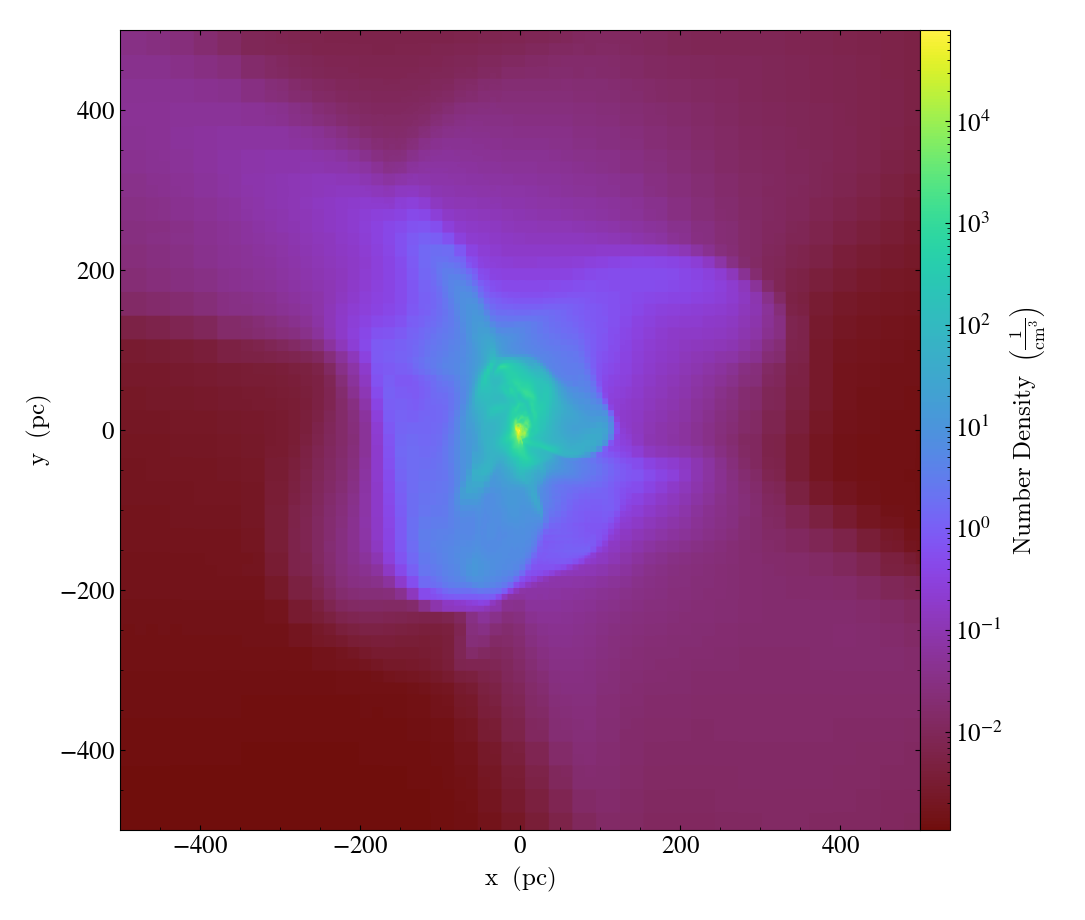

In [51]:
p.show()

In [ ]:
def get_continuum(self, tem, den, He1_H=0., He2_H=0., wl=np.array([3500, 3600, 3700, 3800, 3900]), 
                      cont_HI=True, cont_HeI=True, cont_HeII=True, 
                      cont_2p=True, cont_ff=True, HI_label='11_2'):
        """
        
        Type of continuum to take into acount defined a boolean, defaults are True
        
        Parameters:
            tem: temperature [K]. May be a float or an iterable.
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem.
            He1_H (float):  He+/H+ abundance. Default = 0.0
            He2_H (float): He++/H+ abundances.  Default = 0.0
            wl (np.array): Wavelengths Default = np.array([3500, 3600, 3700, 3800, 3900])
            cont_HI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeII (bool): using B. Ercolano 2006 data. Default: True
            cont_2p (bool): 2 photons, using D. Pequignot fit to Osterbrock. Default: True
            cont_ff (bool): from Storey & Hummer 1991. Default: True
            
            HI_label (str): HI label to normalize the continuum. If None, no normalization is done. Default: '11_2'
            
        Returns:
            The resulting continuum. Unit [A-1] if normalized, [erg/s.cm3/A] otherwise
        
        Exemple of use:
            C = pn.Continuum()
            wl = np.arange(3500, 4000, 1)
            cont = C.get_continuum(tem=1e4, den=1e2, He1_H=0.08, He2_H=0.02, wl=wl)
            plt.plot(wl, cont)
        """
        try:
            _ = (e for e in tem)
            T_iterable = True
            try:
                _ = (e for e in den)
            except:
                den = np.ones_like(tem) * den
            try:
                _ = (e for e in He1_H)
            except:
                He1_H = np.ones_like(tem) * He1_H
            try:
                _ = (e for e in He2_H)
            except:
                He2_H = np.ones_like(tem) * He2_H
            
        except TypeError:
            T_iterable = False
        if HI_label is None:
            norm = 1.0
        else:
            if self.HI is None:
                self.HI = pn.RecAtom('H',1)
            norm = self.HI.getEmissivity(tem, den, label = HI_label, product=False)
            
        if T_iterable:
            cont = np.array(list(map(lambda t, d, He1_H_1,He2_H_1 : self._get_continuum1(t, d, 
                                                                                  He1_H=He1_H_1, 
                                                                                  He2_H=He2_H_1, 
                                                                                  wl=wl, 
                                                                                  cont_HI=cont_HI, 
                                                                                  cont_HeI=cont_HeI, 
                                                                                  cont_HeII=cont_HeII, 
                                                                                  cont_2p=cont_2p, 
                                                                                  cont_ff=cont_ff), 
                                     tem, den, He1_H, He2_H))).T
            return cont.squeeze()/norm
        else:
            cont = self._get_continuum1(tem, den, He1_H=He1_H, He2_H=He2_H, wl=wl, 
                                        cont_HI=cont_HI, cont_HeI=cont_HeI, cont_HeII=cont_HeII, 
                                        cont_2p=cont_2p, cont_ff=cont_ff)
            return cont/norm

In [63]:
print(dir(ds.fields.gas))

['El_number_density', 'H_nuclei_density', 'H_p1_number_density', 'He_nuclei_density', 'He_p2_number_density', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'angular_momentum_magnitude', 'angular_momentum_x', 'angular_momentum_y', 'angular_momentum_z', 'averaged_density', 'baroclinic_vorticity_magnitude', 'baroclinic_vorticity_x', 'baroclinic_vorticity_y', 'baroclinic_vorticity_z', 'baryon_overdensity', 'cell_mass', 'cell_volume', 'courant_time_step', 'cutting_plane_velocity_x', 'cutting_plane_velocity_y', 'cutting_plane_velocity_z', 'density', 'density_gradient_magnitude', 'density_gradient_x', 'density_gradient_y', 'density_gradient_z', 'dx', 'dy', 'dynamical_time', 'dz', 'emission_measure', 'entropy', 'four_velocity_magnitude', 'four_velocity_t', 'four_velocity_x', 'four_velocity_y', 'four_velocity_z', 'jeans_mass', 'kT', 'kinetic_energy_density', 'lorentz_factor', 'mach_number', 'mass', 'mazzotta_weighting', 'mean_molecular_weight', 'metal_mass', 'metallicity', 'momentum_den

In [64]:
def get_continuum(self, tem, den, He1_H=0., He2_H=0., wl=np.array([3500, 3600, 3700, 3800, 3900]), 
                      cont_HI=True, cont_HeI=True, cont_HeII=True, 
                      cont_2p=True, cont_ff=True, HI_label='11_2'):
        """
        
        Type of continuum to take into acount defined a boolean, defaults are True
        
        Parameters:
            tem: temperature [K]. May be a float or an iterable.
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem.
            He1_H (float):  He+/H+ abundance. Default = 0.0
            He2_H (float): He++/H+ abundances.  Default = 0.0
            wl (np.array): Wavelengths Default = np.array([3500, 3600, 3700, 3800, 3900])
            cont_HI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeII (bool): using B. Ercolano 2006 data. Default: True
            cont_2p (bool): 2 photons, using D. Pequignot fit to Osterbrock. Default: True
            cont_ff (bool): from Storey & Hummer 1991. Default: True
            
            HI_label (str): HI label to normalize the continuum. If None, no normalization is done. Default: '11_2'
            
        Returns:
            The resulting continuum. Unit [A-1] if normalized, [erg/s.cm3/A] otherwise
        
        Exemple of use:
            C = pn.Continuum()
            wl = np.arange(3500, 4000, 1)
            cont = C.get_continuum(tem=1e4, den=1e2, He1_H=0.08, He2_H=0.02, wl=wl)
            plt.plot(wl, cont)
        """
        try:
            _ = (e for e in tem)
            T_iterable = True
            try:
                _ = (e for e in den)
            except:
                den = np.ones_like(tem) * den
            try:
                _ = (e for e in He1_H)
            except:
                He1_H = np.ones_like(tem) * He1_H
            try:
                _ = (e for e in He2_H)
            except:
                He2_H = np.ones_like(tem) * He2_H
            
        except TypeError:
            T_iterable = False
        if HI_label is None:
            norm = 1.0
        else:
            if self.HI is None:
                self.HI = pn.RecAtom('H',1)
            norm = self.HI.getEmissivity(tem, den, label = HI_label, product=False)
            
        if T_iterable:
            cont = np.array(list(map(lambda t, d, He1_H_1,He2_H_1 : self._get_continuum1(t, d, 
                                                                                  He1_H=He1_H_1, 
                                                                                  He2_H=He2_H_1, 
                                                                                  wl=wl, 
                                                                                  cont_HI=cont_HI, 
                                                                                  cont_HeI=cont_HeI, 
                                                                                  cont_HeII=cont_HeII, 
                                                                                  cont_2p=cont_2p, 
                                                                                  cont_ff=cont_ff), 
                                     tem, den, He1_H, He2_H))).T
            return cont.squeeze()/norm
        else:
            cont = self._get_continuum1(tem, den, He1_H=He1_H, He2_H=He2_H, wl=wl, 
                                        cont_HI=cont_HI, cont_HeI=cont_HeI, cont_HeII=cont_HeII, 
                                        cont_2p=cont_2p, cont_ff=cont_ff)
            return cont/norm

In [65]:
from Fitser_v2 import JWST_disperser

In [ ]:
g395h = JWST_disperser("g395h")
z = ds.current_redshift
wavemin = g395h.minwave/(1+z)
wavemax = g395h.maxwave/(1+z)
print(ds)

In [86]:
C = pn.Continuum()
"""
Parameters:
            tem: temperature [K]. May be a float or an iterable.
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem.
            He1_H (float):  He+/H+ abundance. Default = 0.0
            He2_H (float): He++/H+ abundances.  Default = 0.0
            wl (np.array): Wavelengths Default = np.array([3500, 3600, 3700, 3800, 3900])
            cont_HI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeII (bool): using B. Ercolano 2006 data. Default: True
            cont_2p (bool): 2 photons, using D. Pequignot fit to Osterbrock. Default: True
            cont_ff (bool): from Storey & Hummer 1991. Default: True
            
            HI_label (str): HI label to normalize the continuum. If None, no normalization is done. Default: '11_2'
            """
temp = ad['gas', 'temperature'].value
dens = ad['gas', 'number_density'].value

#temp = temp[0]
print(temp)
#dens = dens[0]
print(dens)
# create log-spaced wavelength array
wl = np.logspace(np.log10(wavemin*100), np.log10(wavemax*100), 8000)

# compute continuum emission components
contH = C.get_continuum(
    tem = temp, den = dens, wl = wl, HI_label = None,
    cont_HI = True, cont_HeI = False, cont_HeII = False,  # bound-free emission only
    cont_2p = False, cont_ff = False
)

cont2p = C.get_continuum(
    tem = temp, den = dens, wl = wl, HI_label = None,
    cont_HI = False, cont_HeI = False, cont_HeII = False,  # two-photon emission only
    cont_2p = True, cont_ff = False
)

contff = C.get_continuum(
    tem = temp, den = dens, wl = wl, HI_label = None,
    cont_HI = False, cont_HeI = False, cont_HeII = False,  # free-free emission only
    cont_2p = False, cont_ff = True
)

# plot continuum components
plt.figure(figsize = (12, 8))
plt.plot(wl, contH * wl, label = "Bound-Free (H)")
plt.plot(wl, cont2p * wl, label = "Two-Photon")
plt.plot(wl, contff * wl, label = "Free-Free")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"$4\pi\lambda j_\lambda / (n_e n_p)$ [erg s$^{-1}$ cm$^3$]")
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.title(r"Continuum Spectrum at $\text{temperature} = 5\times10^3$ K and $\text{nunber density} = 10^4$ cm$^{-3}$")
plt.show()

[2.504098   2.70982744 2.59738567 ... 2.0750431  2.15310258 2.11539169]
[0.00086912 0.00090972 0.00095292 ... 0.00059659 0.00065819 0.00064408]
warng Continuum.make_cont_Ercolano: Invalid temperature 2.504098001381467
warng Continuum.make_cont_Ercolano: Invalid temperature 2.7098274354867975
warng Continuum.make_cont_Ercolano: Invalid temperature 2.597385665407544
warng Continuum.make_cont_Ercolano: Invalid temperature 2.793156897347396
warng Continuum.make_cont_Ercolano: Invalid temperature 2.551794243648804
warng Continuum.make_cont_Ercolano: Invalid temperature 2.6597928188756077
warng Continuum.make_cont_Ercolano: Invalid temperature 2.5986314613001773
warng Continuum.make_cont_Ercolano: Invalid temperature 2.691289349243682
warng Continuum.make_cont_Ercolano: Invalid temperature 2.390196706585556
warng Continuum.make_cont_Ercolano: Invalid temperature 2.5256535752061273
warng Continuum.make_cont_Ercolano: Invalid temperature 2.317148977627441
warng Continuum.make_cont_Ercolano: In

ValueError: A value (1.0465459602799515e-09) in x_new is above the interpolation range's maximum value (2.1787106162601336e-11).